# Ames Modeling

Load the dataset, begin modeling.

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from itertools import combinations

In [255]:
housing = pd.read_csv('data/housing_final.csv')
housing2 = pd.read_csv('data/NH_DF.csv')

#housing.count()
#housing.info()
#housing.describe()

# Simple Linear Regression (SLR)

In [219]:
def SLR(X, y):
    #Set up the model
    lm = LinearRegression()
    lm.fit(X, y)
    score=lm.score(X, y)
    return score


# Multiple Linear Regression (MLR)

In [220]:
def MLR(X, y):
    # Split the dataset into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test) # Make predictions on the test set
    r2_value_calculated = r2_score(y_test, y_pred)
    coef = lm.coef_
    return [r2_value_calculated, coef]


# Multiple Linear Regression (MLR) with k-fold CV

In [221]:
def MLR_kfold(X,y,k):
    # Create an instance of KFold with the desired number of folds
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize lists to store RMSE and R-squared values for each fold
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    r2_scores = []
    
    # Iterate over the folds
    i=0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # 2. Modeling (MLR)
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        y_pred = lm.predict(X_test) # Make predictions on the test set
        
        # 3. Evaluation Calculate MAE, MSE, and RMSE for this fold
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Append the scores to the respective lists
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        print(i,"R-squared:", r2)
        i=i+1

    return [rmse_scores, r2_scores]


# Penalized Regression with k-fold CV

In [222]:
# These functions do penalized regression on ridge, lasso, and elastic net
# regression models with k-fold cross validation, and uses GridSearchCV to 
# determine the best alpha

def grid_alpha(X,y,model):
    # Do GridSearchCV to find best alpha
    params = {'alpha': np.linspace(0, 1, 5)}
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', return_train_score=True)
    gX_train, gX_test, gy_train, gy_test = train_test_split(X, y, test_size=0.2, random_state=42)

    gX_train = StandardScaler().fit_transform(gX_train)
    gX_train = pd.DataFrame(gX_train)
    
    grid.fit(gX_train, gy_train)
    best_alpha = grid.best_params_['alpha']
    print("best alpha for ",model,": ",best_alpha)
    return best_alpha
    
def penalized(X,y,k,ratio):
    print("Ridge, Lasso, and Elastic Net with GridSearchCV for alpha")
    print("Features:\n", list(X.columns.values))

    ridge_alpha = grid_alpha(X,y, Ridge())
    lasso_alpha = grid_alpha(X,y, Lasso())
    enet_alpha = grid_alpha(X,y, ElasticNet())
       
    # Create an instance of KFold with the desired number of folds, iterate
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = StandardScaler().fit_transform(X_train)
        X_train = pd.DataFrame(X_train)

        ############################ Create Models ###########################################     
        ridge_model = Ridge(alpha=ridge_alpha) 
        lasso_model = Lasso(alpha=lasso_alpha)
        elasticnet_model = ElasticNet(alpha=enet_alpha, l1_ratio=ratio) # Ratio mixing parameter controls balance between Ridge and Lasso
    
        # Fit the models on the training data
        ridge_model.fit(X_train, y_train)
        lasso_model.fit(X_train, y_train)
        elasticnet_model.fit(X_train, y_train)
    
        ######################### Make predictions using models #############################
        X_test = StandardScaler().fit_transform(X_test)
        X_test = pd.DataFrame(X_test)
        ridge_predictions = ridge_model.predict(X_test)
        lasso_predictions = lasso_model.predict(X_test)
        elasticnet_predictions = elasticnet_model.predict(X_test)
    
        ############################ Evaluate Models #########################################
        # Calculate R-squared for the models
        ridge_r2 = r2_score(y_test, ridge_predictions)
        lasso_r2 = r2_score(y_test, lasso_predictions)
        elasticnet_r2 = r2_score(y_test, elasticnet_predictions)
    
        print("R-squared for Ridge model:", ridge_r2)
        print("R-squared for Lasso model:", lasso_r2)
        print("R-squared for ElasticNet model:", elasticnet_r2)
    

# Feature Selection

In [242]:
numerical_features=['GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea',
 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
 'GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','YrSold', 
 'ScreenPorch','PoolArea','MiscVal','DistanceToISU','YearsSinceRemod','TotalSF'] #'DateSold'
cat_ord_features=['LandSlope','OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual',
 'BsmtCond','HeatingQC','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
 'KitchenAbvGr','KitchenQual','TotRmsAbvGrd','Fireplaces','FireplaceQu','GarageCars',
 'GarageQual','GarageCond','PoolQC','DistanceCategory']
cat_nom_features=['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities',
 'LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
 'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','BsmtExposure','BsmtFinType1',
 'BsmtFinType2','Heating','CentralAir','Electrical','Functional','GarageType','GarageFinish',
 'PavedDrive','Fence','MiscFeature','MoSold','SaleType','SaleCondition']
all_features = numerical_features + cat_ord_features + cat_nom_features
best_features = ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
            'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
            'LowQualFinSF', 'BedroomAbvGr'] #top 15 from one of the combinatorics run
print("Number of numerical feat: ",len(numerical_features))
print("Number of ord feat: ",len(cat_ord_features))
print("Number of nom feat: ",len(cat_nom_features))

Number of numerical feat:  26
Number of ord feat:  23
Number of nom feat:  34


# Running the models

## Running Simple Linear Regression

In [224]:
# Run SLR for all of the variables (non-nominal)

#remove categorical non numeric features
housing_num = housing.select_dtypes(exclude=[object])
features = list(housing_num.columns.values)

results = []
# Loop through each feature and examine the score
for i, feature in enumerate(housing[features]):
    X=housing[[features[i]]]
    y=housing['SalePrice']
    score=SLR(X,y)
    results.append([score,feature])

results.sort(reverse=True)
print("R2 for Simple Linear Regression models: \nscore, feature\n", results[:10])

R2 for Simple Linear Regression models: 
score, feature
 [[1.0, 'SalePrice'], [0.6711961597441903, 'TotalSF'], [0.6251450369427116, 'OverallQual'], [0.5183711142112821, 'GrLivArea'], [0.46592758029312764, 'ExterQual'], [0.42936092301546336, 'KitchenQual'], [0.4258083391417201, 'TotalBsmtSF'], [0.4129649523918614, '1stFlrSF'], [0.4078606795911094, 'GarageCars'], [0.4028516501885737, 'GarageArea']]


## Running Multiple Linear Regression

In [225]:
X = housing[best_features]  # Features
y = housing['SalePrice']  # Target variable

r = MLR(X,y)
print(features)
print("R2 for Multiple Linear Regression model: ", r[0])
print("Coefficient:", r[1])

['GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MA_Zip1', 'latitude', 'longitude', 'DistanceToISU', 'DistanceCategory', 'YearsSinceRemod', 'TotalSF']
R2 for Multiple Linear Regression model:  0.8675827335780187
Coefficient: [ 6.89649435e+01 -1.50239866e+02  8.28546737e+01  5.75939225e-01
  1.65225554e+04  4.54307944e+03  3.72728780e+02  2.20015128e+02
  3.52409699e+01  1.91118792e+01  7

In [226]:
# Run MLR with K-fold CV

# MLR with K-fold Cross Validation
features = ['TotalSF','YearBuilt']
X = housing[features]  # Features
y = housing['SalePrice']  # Target variable

print("MLR with k-fold Cross Validation")
print("Features:\n", features)

r = MLR_kfold(X,y,k=5)

#print("Average RMSE:", avg_rmse)
print("Average R-squared:", np.mean(r[1]))
print("Standard deviation of R-squared:", np.std(r[1]))


MLR with k-fold Cross Validation
Features:
 ['TotalSF', 'YearBuilt']
0 R-squared: 0.7380489512100098
1 R-squared: 0.6996575186312735
2 R-squared: 0.774637078425608
3 R-squared: 0.7603262975781899
4 R-squared: 0.7071450170454274
Average R-squared: 0.7359629725781016
Standard deviation of R-squared: 0.029127890148053233


## Running Ridge, Lasso, and Elastic Net

In [227]:
X = housing[best_features]  # Features
y = housing['SalePrice']  # Target variable

penalized(X,y,k=5,ratio=0.5)

Ridge, Lasso, and Elastic Net with GridSearchCV for alpha
Features:
 ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BedroomAbvGr']
best alpha for  Ridge() :  1.0
best alpha for  Lasso() :  1.0
best alpha for  ElasticNet() :  0.0
R-squared for Ridge model: 0.8634672647469678
R-squared for Lasso model: 0.8626984054582573
R-squared for ElasticNet model: 0.8626983311811577
R-squared for Ridge model: 0.8078525889431117
R-squared for Lasso model: 0.8077947348898475
R-squared for ElasticNet model: 0.8077908412003998
R-squared for Ridge model: 0.871864644093898
R-squared for Lasso model: 0.872147636530772
R-squared for ElasticNet model: 0.8721513407928876
R-squared for Ridge model: 0.857964937332202
R-squared for Lasso model: 0.8580185970351515
R-squared for ElasticNet model: 0.8580178665710935
R-squared for Ridge model: 0.8503479415388738
R-s

## Running categorical var for Vinod

In [228]:
# Run MLR for Vinod's question about categorical variables

#features = ['TotalSF','YearBuilt']
#features = ['TotalSF','OverallQual']
features = ['TotalSF','Neighborhood']
X = housing[features]  # Features

# Convert categorical columns to one-hot encoding
X = pd.get_dummies(X, columns=['Neighborhood'], drop_first=True)
y = housing['SalePrice']  # Target variable

r = MLR(X,y)
print(features)
print("R2 for Multiple Linear Regression model: ", r[0])
print("Coefficient:", r[1])

['TotalSF', 'Neighborhood']
R2 for Multiple Linear Regression model:  0.7763283731202626
Coefficient: [ 5.76623354e+01  2.68750483e+02 -2.85742151e+04 -2.78161496e+04
  1.90025477e+03  7.70519275e+03  5.10878279e+03 -2.92278115e+04
  8.79227650e+03  2.77956451e+04  1.16860989e+05 -4.16703597e+04
  1.89174898e-10 -3.95377614e+04 -1.27867761e+04 -2.77101493e+04
 -2.14230997e+04 -1.45867474e+04  6.30438067e+04  7.09462910e+04
 -3.97147689e+04 -4.62714763e+04 -2.09358025e+04 -2.02819054e+03
  3.05764242e+04  6.71063401e+04  2.21616463e+04  1.89668790e+04]


## Results for Vinod's Question Regarding Categorical Variables
3. 

    A) using 2 numerical features.
   
    MLR with k-fold Cross Validation
    Features:
     ['TotalSF', 'YearBuilt']
    0 R-squared: 0.7416625031183677
    1 R-squared: 0.7217569726901124
    2 R-squared: 0.7396252336514776
    3 R-squared: 0.7284613561793205
    4 R-squared: 0.7450915795474258
    Average R-squared: 0.7353195290373409
    Standard deviation of R-squared: 0.008777731520280862

    ['TotalSF', 'YearBuilt']
    R2 for Multiple Linear Regression model:  0.7416625031183677
    Coefficient: [ 70.20861997 706.57551685]

    B) One using 1 numerical + 1 ordinal (categorial)

    MLR with k-fold Cross Validation
    Features:
     ['TotalSF', 'OverallQual']
    0 R-squared: 0.792774534309626
    1 R-squared: 0.7624705587335859
    2 R-squared: 0.7877980662360704
    3 R-squared: 0.7687533574218369
    4 R-squared: 0.8070790469236628
    Average R-squared: 0.7837751127249565
    Standard deviation of R-squared: 0.01624674888158771

    ['TotalSF', 'OverallQual']
    R2 for Multiple Linear Regression model:  0.792774534309626
    Coefficient: [   51.60485606 24634.19345553]

    C) One using 1 numerical + 1 nominal (categorical)

    ['TotalSF', 'Neighborhood']
    R2 for Multiple Linear Regression model:  0.7752658566982651
    Coefficient: [ 5.85357913e+01 -1.44534936e+04 -3.07217621e+04 -2.92747827e+04
     -4.59607469e+03  6.31958875e+03  1.76623599e+03 -3.17566089e+04
      4.64969094e+03  2.13902795e+04  1.15656923e+05 -4.11100342e+04
     -1.56651870e+04 -3.97234514e+04 -1.44459331e+04 -2.93749044e+04
     -2.54999577e+04 -1.80343378e+04  6.29015223e+04  6.86566889e+04
     -4.12164036e+04 -4.47433094e+04 -2.49892035e+04 -4.02619715e+03
      2.83089424e+04  6.73020370e+04  2.10537330e+04  1.83914854e+04]

    MLR with k-fold Cross Validation
    Features:
     ['TotalSF', 'Neighborhood']
    0 R-squared: 0.775265856698265
    1 R-squared: 0.7993892323818912
    2 R-squared: 0.7863056427419447
    3 R-squared: 0.7871833976141214
    4 R-squared: 0.7807599813736235
    Average R-squared: 0.7857808221619691
    Standard deviation of R-squared: 0.008039960499637195



##  Multiple Linear Regression using Combinatorics for Feature Selection

In [66]:
# Run MLR for all combinations of features to determine the best combi

#remove categorical non numeric features
housing_num = housing.select_dtypes(exclude=[object])
features = list(housing_num.columns.values)
features.remove('SalePrice')
features.remove('BsmtFinSF1')
features.remove('BsmtFinSF2')
features.remove('BsmtUnfSF')
features.remove('1stFlrSF')
features.remove('2ndFlrSF')
features.remove('LowQualFinSF')
features.remove('MA_Zip1')
features.remove('latitude')
features.remove('longitude')
features.remove('YearRemodAdd')
#['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
#            'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
#            'LowQualFinSF', 'BedroomAbvGr']

print(features)
n = len(features)
print("Total num features:",n)

# Get all combinations
results = []
for i in range(10,10+1,1):
    print(i, "features")
    #comb = combinations(features, i)
    #2481256778
    #print(sum(1 for _ in comb))
    #for c in comb:
        #take contents of this for loop and make a function for it where c is the only arg
        #time.sleep(.01)
        #X = housing[list(c)]  # Features
        #y = housing['SalePrice']  # Target variable
        #r = MLR(X, y)
        #if r[0] > 0.8: 
            #results.append([r[0],list(c)])
            #print(r[0])

#results.sort(reverse=True)
print("R2 for Multiple Linear Regression models: score, features", results[:20])
#results.sort(reverse=True)
    #calculate tolerance (the R2 between features)

#print("R2 for Multiple Linear Regression model: ", r[0])


['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'TotalBsmtSF', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'DistanceToISU', 'DistanceCategory', 'YearsSinceRemod', 'TotalSF']
Total num features: 44
10 features
R2 for Multiple Linear Regression models: score, features []


# LazyPredict Results

In [229]:
from lazypredict.Supervised import LazyRegressor

features = ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
            'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
            'LowQualFinSF', 'BedroomAbvGr']
X = housing[features]  # Features
y = housing['SalePrice']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)


  5%|██                                          | 2/42 [00:00<00:04,  8.61it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8205310585523525, 'Adjusted R-Squared': 0.8151469903089231, 'RMSE': 33088.7213838237, 'Time taken': 0.1367032527923584}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8799442607341706, 'Adjusted R-Squared': 0.8763425885561957, 'RMSE': 27063.053619644244, 'Time taken': 0.10142660140991211}
{'Model': 'BayesianRidge', 'R-Squared': 0.8674139185648957, 'Adjusted R-Squared': 0.8634363361218426, 'RMSE': 28440.30846561372, 'Time taken': 0.006885528564453125}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.758240199815496, 'Adjusted R-Squared': 0.7509874058099608, 'RMSE': 38404.08116291699, 'Time taken': 0.019566059112548828}
{'Model': 'DummyRegressor', 'R-Squared': -0.004594622264182835, 'Adjusted R-Squared': -0.034732460932108244, 'RMSE': 78285.39718401998, 'Time taken': 0.004118919372558594}
{'Model': 'ElasticNet', 'R-Squared': 0.8234190427850925, 'Adjusted R-Squared': 0.8181216140686453, 'RMSE': 32821.41256106356, 'Time taken': 0.005008935928344

 21%|█████████▍                                  | 9/42 [00:00<00:02, 13.04it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8932526059955371, 'Adjusted R-Squared': 0.8900501841754033, 'RMSE': 25519.01901936324, 'Time taken': 0.40674757957458496}
{'Model': 'GammaRegressor', 'R-Squared': 0.8100462727123632, 'Adjusted R-Squared': 0.8043476608937341, 'RMSE': 34041.54359477288, 'Time taken': 0.007683515548706055}


 26%|███████████▎                               | 11/42 [00:01<00:03,  9.88it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.3505677012846462, 'Adjusted R-Squared': -0.39108473232318564, 'RMSE': 90770.24643510651, 'Time taken': 0.3346066474914551}


 31%|█████████████▎                             | 13/42 [00:01<00:04,  6.96it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9068348509966664, 'Adjusted R-Squared': 0.9040398965265664, 'RMSE': 23840.31976893871, 'Time taken': 0.31296730041503906}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8996214336450276, 'Adjusted R-Squared': 0.8966100766543784, 'RMSE': 24746.046755185303, 'Time taken': 0.18484163284301758}
{'Model': 'HuberRegressor', 'R-Squared': 0.8582798315903399, 'Adjusted R-Squared': 0.8540282265380501, 'RMSE': 29403.64459218172, 'Time taken': 0.01530909538269043}


 38%|████████████████▍                          | 16/42 [00:01<00:02,  8.81it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.856598617932631, 'Adjusted R-Squared': 0.85229657647061, 'RMSE': 29577.536796151133, 'Time taken': 0.022526264190673828}
{'Model': 'KernelRidge', 'R-Squared': -4.269998364765882, 'Adjusted R-Squared': -4.4280983157088585, 'RMSE': 179304.2464536739, 'Time taken': 0.18683457374572754}
{'Model': 'Lars', 'R-Squared': 0.867582733578021, 'Adjusted R-Squared': 0.8636102155853616, 'RMSE': 28422.196910339302, 'Time taken': 0.010738849639892578}


 57%|████████████████████████▌                  | 24/42 [00:01<00:00, 19.72it/s]

{'Model': 'LarsCV', 'R-Squared': 0.8670434790252511, 'Adjusted R-Squared': 0.8630547833960087, 'RMSE': 28480.011223456266, 'Time taken': 0.01596546173095703}
{'Model': 'Lasso', 'R-Squared': 0.8675802717315007, 'Adjusted R-Squared': 0.8636076798834457, 'RMSE': 28422.46111591928, 'Time taken': 0.005704402923583984}
{'Model': 'LassoCV', 'R-Squared': 0.8672826860556669, 'Adjusted R-Squared': 0.8633011666373369, 'RMSE': 28454.379965095646, 'Time taken': 0.0413668155670166}
{'Model': 'LassoLars', 'R-Squared': 0.8675780849857149, 'Adjusted R-Squared': 0.8636054275352864, 'RMSE': 28422.695795605177, 'Time taken': 0.006058216094970703}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8670434790252511, 'Adjusted R-Squared': 0.8630547833960087, 'RMSE': 28480.011223456266, 'Time taken': 0.012880563735961914}
{'Model': 'LassoLarsIC', 'R-Squared': 0.867582733578021, 'Adjusted R-Squared': 0.8636102155853616, 'RMSE': 28422.196910339302, 'Time taken': 0.006649971008300781}
{'Model': 'LinearRegression', 'R-Squar

 67%|████████████████████████████▋              | 28/42 [00:02<00:01, 11.55it/s]

{'Model': 'MLPRegressor', 'R-Squared': -5.239175641512125, 'Adjusted R-Squared': -5.426350910757488, 'RMSE': 195096.2585141027, 'Time taken': 0.5444719791412354}
{'Model': 'NuSVR', 'R-Squared': -0.030689214240415152, 'Adjusted R-Squared': -0.061609890667627676, 'RMSE': 79295.62024903082, 'Time taken': 0.11081600189208984}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6201582397185916, 'Adjusted R-Squared': 0.6087629869101494, 'RMSE': 48137.85005332148, 'Time taken': 0.0059661865234375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8297941610295614, 'Adjusted R-Squared': 0.8246879858604482, 'RMSE': 32223.48901911773, 'Time taken': 0.00817108154296875}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8550732192609536, 'Adjusted R-Squared': 0.8507254158387823, 'RMSE': 29734.432729828448, 'Time taken': 0.037697553634643555}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9105024147523184, 'Adjusted R-Squared': 0.907817487194888, 'RMSE': 23366.356244195755, 'Time taken'

 79%|█████████████████████████████████▊         | 33/42 [00:02<00:00, 15.73it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.7831966532569323, 'Adjusted R-Squared': 0.7766925528546402, 'RMSE': 36367.908510473026, 'Time taken': 0.051082611083984375}


 93%|███████████████████████████████████████▉   | 39/42 [00:03<00:00,  9.56it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8961800839920554, 'Adjusted R-Squared': 0.893065486511817, 'RMSE': 25166.665190007374, 'Time taken': 0.9089891910552979}
{'Model': 'Ridge', 'R-Squared': 0.8675490978903028, 'Adjusted R-Squared': 0.8635755708270119, 'RMSE': 28425.806482806696, 'Time taken': 0.004996061325073242}
{'Model': 'RidgeCV', 'R-Squared': 0.8672415818798355, 'Adjusted R-Squared': 0.8632588293362305, 'RMSE': 28458.78595877177, 'Time taken': 0.0055751800537109375}
{'Model': 'SGDRegressor', 'R-Squared': 0.8577676788180216, 'Adjusted R-Squared': 0.8535007091825623, 'RMSE': 29456.7265828301, 'Time taken': 0.0073735713958740234}
{'Model': 'SVR', 'R-Squared': -0.08647908703320017, 'Adjusted R-Squared': -0.11907345964419624, 'RMSE': 81413.42404498698, 'Time taken': 0.15787625312805176}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.867582733578021, 'Adjusted R-Squared': 0.8636102155853616, 'RMSE': 28422.196910339306, 'Time taken': 0.005678892135620117}
{'Model': '

100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 10.70it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9006768056671969, 'Adjusted R-Squared': 0.8976971098372127, 'RMSE': 24615.61405557824, 'Time taken': 0.08706164360046387}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1935
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 15
[LightGBM] [Info] Start training from score 176994.167717
{'Model': 'LGBMRegressor', 'R-Squared': 0.9023093016364713, 'Adjusted R-Squared': 0.8993785806855654, 'RMSE': 24412.48233080444, 'Time taken': 0.056641340255737305}
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
PoissonRegressor                             0.91       0.91  23366.36   
GradientBoostingRegressor                    0.90       0.91  23840.32   
LGBMRegressor                 

# VIF

In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame with your features (X)
X = housing[['OverallQual', 'TotalSF', 'GarageCars', 'Fireplaces', 'YearRemodAdd']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"]

0    41.778207
1    21.049467
2    10.811683
3     2.397206
4    22.849588
Name: VIF, dtype: float64

In [68]:
#High multicollinearity above. If YearRemodAdd is removed, it's improved

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame with your features (X)
X = housing[['OverallQual', 'TotalSF', 'GarageCars', 'Fireplaces']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"]

0    21.868821
1    20.630049
2    10.773760
3     2.289568
Name: VIF, dtype: float64

# RandomForestRegressor

In [245]:
X = housing[all_features] # Features
y = housing['SalePrice']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, cat_nom_features)])

# Append classifier to preprocessing pipeline.
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestRegressor(n_estimators=100, random_state=42))])

# Preprocessing of training data and train model
pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(f'R^2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')


R^2 Score: 0.8878546237165814
RMSE: 26156.28260652973


In [246]:
# Compute the R^2 scores
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# Print R^2 score for each fold
for i, score in enumerate(scores, 1):
    print(f"R^2 Score for fold {i}: {score:.4f}")

# Print average R^2 score
print(f"\nAverage R^2 Score across the 5 folds: {scores.mean():.4f}")


R^2 Score for fold 1: 0.8286
R^2 Score for fold 2: 0.8851
R^2 Score for fold 3: 0.8522
R^2 Score for fold 4: 0.8748
R^2 Score for fold 5: 0.8474

Average R^2 Score across the 5 folds: 0.8576


In [232]:
# Convert categorical columns to one-hot encoding
X_train = pd.get_dummies(X_train)

# Handle missing data by filling with the mean value of each column
X_train.fillna(X_train.mean(), inplace=True)

# Now, try training the model again
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# To sort features by importance
sorted_idx = importances.argsort()
for idx in sorted_idx:
    print(f"{X_train.columns[idx]}: {importances[idx]}")


RoofMatl_Roll: 0.0
MiscFeature_TenC: 0.0
Exterior1st_ImStucc: 6.516845348220786e-10
RoofStyle_Shed: 2.4530308859494837e-09
SaleType_VWD: 8.874364654950598e-09
Condition2_PosA: 1.362926385819624e-08
Utilities_AllPub: 1.9795548124302848e-08
Exterior1st_AsphShn: 3.004548675890518e-08
Exterior1st_CBlock: 4.251077258915533e-08
Exterior2nd_CBlock: 5.172542905579538e-08
Condition2_Artery: 8.155829135309487e-08
Heating_Grav: 2.0400547596103234e-07
Condition1_RRNe: 2.2020232412704783e-07
Condition2_RRAn: 2.7920067404218205e-07
SaleCondition_Alloca: 3.057234134283305e-07
Condition2_RRNn: 4.674079805989428e-07
MiscFeature_Othr: 4.7385554646302794e-07
MSZoning_I (all): 5.6419092427713e-07
SaleCondition_AdjLand: 6.05368908455553e-07
Condition1_RRNn: 7.686516104657002e-07
Fence_MnWw: 8.300870780495864e-07
Heating_Wall: 8.940412510029913e-07
Exterior1st_PreCast: 1.1544170936746691e-06
MiscFeature_Gar2: 1.1906507287364908e-06
RoofMatl_WdShake: 1.269678567160348e-06
Street_Grvl: 1.3097156578975655e-06


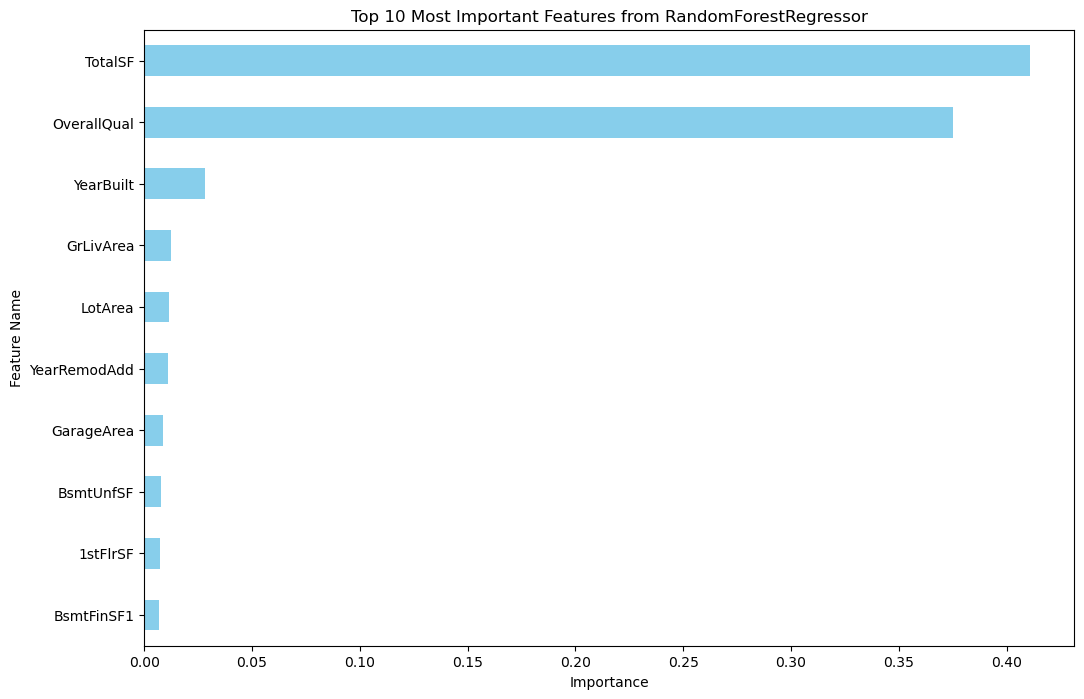

In [233]:
# Map importances to the column names
feature_importances = pd.Series(importances, index=X_train.columns)
top_10 = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
top_10.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Important Features from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # to have the most important feature at the top
plt.show()


# XGBoost Regressor

In [234]:
# Define your feature matrix and target variable, with dummy variables for categorical columns
X = pd.get_dummies(housing[all_features], columns=cat_nom_features, drop_first=True)
y = housing['SalePrice']

# Initialize the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE and R2 scores for each fold
rmse_scores = []
r2_scores = []

# Perform k-fold cross-validation
fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create an XGBoost regressor model
    model = xgb.XGBRegressor(objective="reg:squarederror")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    # Calculate R2 for this fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    # Display RMSE and R2 for this fold
    print(f"Fold {fold}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    fold += 1

# Calculate and print the mean RMSE and R2 across all folds
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R2: {mean_r2:.4f}")


Fold 1: RMSE = 22576.2231, R2 = 0.9165
Fold 2: RMSE = 30804.9728, R2 = 0.8481
Fold 3: RMSE = 24263.3972, R2 = 0.9080
Fold 4: RMSE = 21934.4533, R2 = 0.9072
Fold 5: RMSE = 20828.5308, R2 = 0.8948
Mean RMSE: 24081.5154
Mean R2: 0.8949


In [165]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'lambda': [0, 0.5, 1],
    'alpha': [0, 0.5, 1]
}

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
print(f"Best hyperparameters: {grid_search.best_params_}")

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Best hyperparameters: {'alpha': 1, 'colsample_bytree': 1.0, 'gamma': 0.0, 'lambda': 0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 1.0}


In [235]:
# Create an XGBoost regressor model (if you haven't already)
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(25))


                  Feature  Importance
27            OverallQual        0.34
25                TotalSF        0.13
152   Exterior1st_CemntBd        0.05
44             GarageCars        0.05
40            KitchenQual        0.03
31               BsmtQual        0.03
69            MSZoning_RM        0.03
29              ExterQual        0.03
206          CentralAir_Y        0.02
166   Exterior2nd_CmentBd        0.02
39           KitchenAbvGr        0.02
219    GarageType_BuiltIn        0.02
68            MSZoning_RL        0.01
46             GarageCond        0.01
43            FireplaceQu        0.01
89   Neighborhood_Crawfor        0.01
42             Fireplaces        0.01
3               YearBuilt        0.01
34           BsmtFullBath        0.01
53          MSSubClass_60        0.01
12           LowQualFinSF        0.01
252          SaleType_New        0.01
28            OverallCond        0.01
4            YearRemodAdd        0.01
226          PavedDrive_P        0.00


In [107]:


# Set negatively correlated neighborhoods to zero
negative_neighborhoods = [
    'Neighborhood_OldTown', 'Neighborhood_NAmes', 'Neighborhood_Edwards',
    'Neighborhood_IDOTRR', 'Neighborhood_BrkSide', 'Neighborhood_MeadowV',
    'Neighborhood_Sawyer', 'Neighborhood_BrDale', 'Neighborhood_SWISU',
    'Neighborhood_NPkVill', 'Neighborhood_Mitchel', 'Neighborhood_Landmrk'
]
for neighborhood in negative_neighborhoods:
    housing_coordinates[neighborhood] = 0

# Assuming the target is 'SalePrice' and other columns are features
X = housing_coordinates.drop(['SalePrice', 'LogSalePrice', 'LogGrLivArea'], axis=1)
y = housing_coordinates['SalePrice']

# Drop non-numeric columns
X = X.select_dtypes(include=['float64', 'int64'])


XBG with negatively correlated neighborhods set to 0
MSE for each fold: [119006348.07399593, 240176930.25097805, 148573369.38060457, 207340991.9758226, 128881195.3494363]
R^2 for each fold: [0.9789268670844546, 0.9601354750350116, 0.9724910910695423, 0.968221400680643, 0.9750483206791408]


In [110]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'lambda': [0, 0.5, 1],
    'alpha': [0, 0.5, 1]
}

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
print(f"Best hyperparameters: {grid_search.best_params_}")


Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Best hyperparameters: {'alpha': 0, 'colsample_bytree': 1.0, 'gamma': 0.0, 'lambda': 1, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}


In [236]:
best_params = {
    'alpha': 0,
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'lambda': 1,
    'max_depth': 3,
    'min_child_weight': 5,
    'subsample': 1.0,
    'objective': 'reg:squarederror'  # This is the default for regression tasks in XGBoost
}
#grid_search.best_params_
model = xgb.XGBRegressor(**grid_search.best_params_)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    

print("MSE for each fold:", mse_scores)
print("R^2 for each fold:", r2_scores)
print("Average MSE:", sum(mse_scores) / len(mse_scores))
print("Average R^2:", sum(r2_scores) / len(r2_scores))



MSE for each fold: [364865391.4415655, 664446329.5914719, 287231368.79745317, 318828947.8644199, 582845089.3647461]
R^2 for each fold: [0.9403088625519419, 0.8554917769027186, 0.952272338507846, 0.9344897616134662, 0.9108649702632537]
Average MSE: 443643425.41193134
Average R^2: 0.9186855419678454


# Gradient Boosting Regressor

## First run with no tuning

In [247]:
X = housing[all_features]
y = housing['SalePrice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, cat_nom_features)])

# Append classifier to preprocessing pipeline.
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GradientBoostingRegressor(random_state=42))])

# Preprocessing of training data and train model
pipeline.fit(X_train, y_train)
# Predict on test data
y_pred = pipeline.predict(X_test)
   
# Calculate RMSE for this fold
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

#print(r2)
# Compute the R^2 scores
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
# Print average R^2 score
print(f"\nAverage R^2 Score across the 5 folds: {scores.mean():.4f}")


Average R^2 Score across the 5 folds: 0.8677


In [207]:
param_grid = {
    'max_depth': [3, 5, 6, 7],
    'min_weight_fraction_leaf': [0, 0.25, 0.5],
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'subsample': [0.7, 0.8, 0.9],
    'alpha': [0, 0.5, 0.9]
}
#['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 
# 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 
# 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 
# 'tol', 'validation_fraction', 'verbose', 'warm_start']

# Define your feature matrix and target variable, with dummy variables for categorical columns
X = pd.get_dummies(housing[all_features], columns=cat_nom_features, drop_first=False)
y = housing['SalePrice']

model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
print(f"Best hyperparameters: {grid_search.best_params_}")



Fitting 3 folds for each of 23328 candidates, totalling 69984 fits
Best hyperparameters: {'alpha': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0, 'n_estimators': 600, 'subsample': 0.7}


In [254]:
#X.to_csv('data/CharlotteX.csv', index=False)
#y.to_csv('data/y.csv', index=False)

In [257]:
#My best hyperparameters: {'alpha': 0.5, 'max_depth': 5, 'min_weight_fraction_leaf': 0, 'subsample': 0.8}
#0.9219231402135216
#Best hyperparameters: {'alpha': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 
#'min_samples_split': 10, 'min_weight_fraction_leaf': 0, 'n_estimators': 600, 'subsample': 0.7}
#0.9279361418087255
new_param = {
    'max_depth': 3,
    'min_weight_fraction_leaf': 0,
    'n_estimators': 4000,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'alpha': 0.5
}

nick_param = {
    'max_depth': 3,
    'n_estimators': 6000,
    'min_samples_split': 5,
    'learning_rate': 0.008,
    'subsample': 0.3
}
#Nicks 1st: n_estimators=10100, max_depth=4, learning_rate=0.01,min_samples_leaf=1, subsample=0.5, random_state=42
#Nicks best: learning_rate=0.008, max_depth=3, min_samples_split=5, n_estimators=6000, subsample=0.3

# Define your feature matrix and target variable, with dummy variables for categorical columns
X = housing2.drop('SalePrice', axis=1)
y = housing2['SalePrice']

#X = pd.get_dummies(housing[all_features], columns=cat_nom_features, drop_first=True)
#y = housing['SalePrice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model = GradientBoostingRegressor(**grid_search.best_params_)
model = GradientBoostingRegressor(**nick_param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(r2)
# Compute the R^2 scores
scores = cross_val_score(GradientBoostingRegressor(**nick_param, random_state=42), X_train, y_train, cv=5, scoring='r2')
# Print average R^2 score
print(f"\nAverage R^2 Score across the 5 folds: {scores.mean():.4f}")

0.9482111693987879

Average R^2 Score across the 5 folds: 0.9410


In [258]:
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(25))

                  Feature  Importance
36                TotalSF        0.35
3             OverallQual        0.26
35                    Age        0.03
0               GrLivArea        0.02
7              BsmtFinSF1        0.02
2                 LotArea        0.02
6              MasVnrArea        0.02
45          KitchenQual_n        0.02
38             BsmtQual_n        0.02
19             GarageArea        0.02
5            YearRemodAdd        0.02
18             GarageCars        0.01
9               BsmtUnfSF        0.01
11               1stFlrSF        0.01
41          FireplaceQu_n        0.01
4             OverallCond        0.01
10            TotalBsmtSF        0.01
240  SaleCondition_Family        0.01
1             LotFrontage        0.01
40            ExterQual_n        0.01
29               latitude        0.01
46         BsmtExposure_n        0.01
12               2ndFlrSF        0.01
24            ScreenPorch        0.00
50         GarageFinish_n        0.00


Checklist

    which missing values to fill, which to leave
    how to fill missing
    how to do the fold - stratified kfold
    to leave dummies/convert to numerical